# Dog Breeding Image Classification

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

This notebook will develop an image classification model which predicts the dog breed from an image. The code , developed to run on AWS Sagemaker using Pytorch model architecture, will conduct transfer learning using a convolutional neural network (CNN). The CNN architecture we have used in ResNet18. Hyperparamter tuning will be applied to find the best parameters to refine the model, and we will use AWS Debugger and Profiler to understand accuracy and computatinal performance respectively. 

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import os
import sagemaker
import boto3
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
    CollectionConfig
)

from sagemaker.debugger import ( 
    ProfilerRule, 
    ProfilerConfig, 
    FrameworkProfile
)

# from io import BytesIO
# from zipfile import *

In [4]:
# bucket = 'lesson4project'
# prefix = "imageproject"
role = sagemaker.get_execution_role()

## Dataset
Class distrubitions : 
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

This is a dog classificatoin dataset , further information can be found [*https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip*] There are 133 classes and the dataset is split into three folders - train, validation and test. The dataset split as follows:
6680 images for the training set
835 images for the validation set
836 images for the test set

In the following cells we download the data and upload to a S3 bucket.


In [5]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

# --2022-01-06 19:50:15--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 3.5.163.157
# Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|3.5.163.157|:443... connected.
# HTTP request sent, awaiting response... 200 OK
# Length: 1132023110 (1.1G) [application/zip]
# Saving to: ‘dogImages.zip’

# dogImages.zip       100%[===================>]   1.05G  38.8MB/s    in 43s     

# 2022-01-06 19:51:01 (24.9 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]


In [6]:
# !unzip dogImages.zip
# Archive:  dogImages.zip
#    creating: dogImages/
#    creating: dogImages/test/
#    creating: dogImages/train/
#    creating: dogImages/valid/
#    creating: dogImages/test/001.Affenpinscher/
#   inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
#   inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
#   inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
#   inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg  
#   inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg  


In [7]:
# !aws s3 cp dogImages 's3://lesson4project/imageproject/' --recursive

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

The hyperamaters we chose to tune are :
1. learning rate (lr): Controls how much to change the model in response to the loss when the model weights are updated. If too high the weights change too much and we increase error , if too low the model will take a long time to converge.
2. batch size : We want the highest batch size that will allow for fast training but also without impacting the loss too greatly.
3. epochs: We would like the best model without overfitting the model/ 

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [23]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([64, 128, 256, 512]),
    "epochs": IntegerParameter(2, 4)
}

In [8]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", 
                       "Regex": "average test loss: ([0-9\\.]+)"}]

In [28]:
#TODO: Create estimators for your HPs
estimator = PyTorch(
    entry_point="hpo.py", #training file
    role=role, #execution role
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large",
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [9]:
os.environ['SM_MODEL_DIR']='s3://lesson4project/imageproject/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://lesson4project/imageproject/output/'
os.environ['SM_CHANNEL_TRAINING']='s3://lesson4project/imageproject/'

In [ ]:
# TODO: Fit your HP Tuner :  # TODO: Remember to include your data channels
tuner.fit({"training": 's3://lesson4project/imageproject/'})

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [30]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()


2022-01-23 22:22:37 Starting - Preparing the instances for training
2022-01-23 22:22:37 Downloading - Downloading input data
2022-01-23 22:22:37 Training - Training image download completed. Training in progress.
2022-01-23 22:22:37 Uploading - Uploading generated training model
2022-01-23 22:22:37 Completed - Training job completed


In [31]:
#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()
{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'epochs': '3',
 'lr': '0.0014267005122579185',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-01-23-21-12-44-711"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-758745060942/pytorch-training-2022-01-23-21-12-44-711/source/sourcedir.tar.gz"'}

{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'epochs': '3',
 'lr': '0.0014267005122579185',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-01-23-21-12-44-711"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-758745060942/pytorch-training-2022-01-23-21-12-44-711/source/sourcedir.tar.gz"'}

In [9]:
# hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
#                    "lr": best_estimator.hyperparameters()['lr'],
#                    "epochs": int(best_estimator.hyperparameters()['epochs'])}


hyperparameters = {"batch_size": 128, \
                   "lr": 0.0014267005122579185,
                   "epochs": 3}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [10]:
# TODO: Set up debugging and profiling rules and hooks
# collection_configs=[
#     CollectionConfig(
#         name="CrossEntropyLoss_output_0",
#         parameters={
#             "include_regex": "CrossEntropyLoss_output_0",
#             "train.save_steps": "100",
#             "eval.save_steps": "100"
#         }
#     )
# ]

collection_configs=[
    CollectionConfig(
        name="CrossEntropyLoss_output_0",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "10",
            "eval.save_interval": "1"})]


# hook_config = DebuggerHookConfig(
#     # hook_parameters={"train.save_interval": "100",
#     #  "eval.save_interval": "10"}
# )

hook_config=DebuggerHookConfig(
    collection_configs=collection_configs
)


profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, 
    framework_profile_params=FrameworkProfile(num_steps=1)
)


rules = [
    # profiler rules
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    # debugger rules
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]


In [11]:
# TODO: Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="bestmodel",
    role= role ,
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=hook_config,
    # profiler
    profiler_config=profiler_config,
    # 
)

In [12]:
estimator.fit({"training": 's3://lesson4project/imageproject/'}, wait=True)

2022-02-05 18:57:08 Starting - Starting the training job...
2022-02-05 18:57:25 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-02-05 18:59:02 Downloading - Downloading input data...............
2022-02-05 19:01:23 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-05 19:01:22,557 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-05 19:01:22,560 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-02-05 19:01:22,573 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-05 19:01:22,581 sagemaker_pytorch_container.traini

In [13]:
# FINAL MODEL LOCATION, save it here 
model_location=estimator.model_data

In [14]:
model_location

's3://sagemaker-us-east-1-758745060942/bestmodel-2022-02-05-18-57-07-169/output/model.tar.gz'

In [15]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [16]:
estimator.latest_job_debugger_artifacts_path()

's3://sagemaker-us-east-1-758745060942/bestmodel-2022-02-05-18-57-07-169/debug-output'

In [17]:
# DEGGING OUTPUTS
# plot debuggin outputs
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
#Fetch tensor names and print their lengths
trial.tensor_names()

[2022-02-05 19:25:40.100 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-02-05 19:25:40.119 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-758745060942/bestmodel-2022-02-05-18-57-07-169/debug-output
[2022-02-05 19:25:41.165 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-02-05 19:25:42.186 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [18]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

6

In [19]:
trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [20]:
# len(trial.tensor("CrossEntropyLoss_input_0").steps(mode=ModeKeys.EVAL))

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


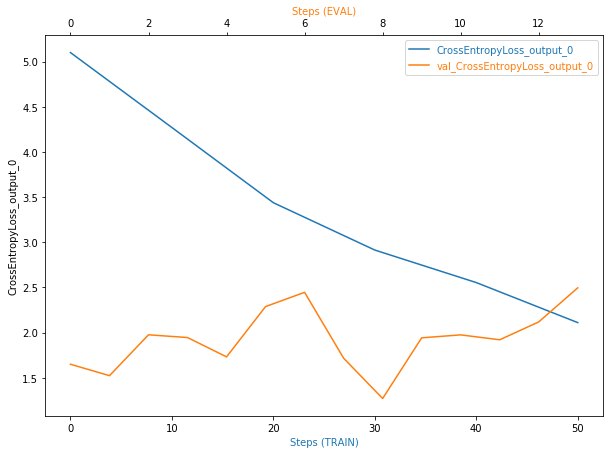

In [21]:
#Set up functions to plot the output tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    
    
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [29]:
# There is an error as there is not loss displayed, will need to come back and review

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  

The bebugger has not captured many data points.

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?


In [53]:
import boto3
session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")



# get the training job object using the training job name and display the system metrics. 
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

Training jobname: bestmodel-2022-01-23-22-51-52-856
Region: us-east-1


ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-758745060942/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-758745060942/bestmodel-2022-01-23-22-51-52-856/profiler-output


Profiler data from system is available


[2022-01-23 23:37:48.630 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO metrics_reader_base.py:134] Getting 40 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


In [55]:
# PROFILER REPORT
#The profiler report will be saved in an S3 bucket.
# Below we can see how to get the path of the report, fetch it and display it. 

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

! aws s3 ls {rule_output_path} --recursive

! aws s3 cp {rule_output_path} ./ --recursive

In [56]:
rule_output_path

's3://sagemaker-us-east-1-758745060942/bestmodel-2022-01-23-22-51-52-856/rule-output'

In [55]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

# IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

2022-01-23 23:33:46     375846 bestmodel-2022-01-23-22-51-52-856/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-23 23:33:45     223778 bestmodel-2022-01-23-22-51-52-856/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-23 23:33:40        192 bestmodel-2022-01-23-22-51-52-856/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-23 23:33:40        200 bestmodel-2022-01-23-22-51-52-856/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-23 23:33:40       1803 bestmodel-2022-01-23-22-51-52-856/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-23 23:33:40        127 bestmodel-2022-01-23-22-51-52-856/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-23 23:33:40        199 bestmodel-2022-01-23-22-51-52-856/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
2022-01-23 23:33:40      

## Model Deploying

In [ ]:
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role
role = get_execution_role()
# You can also configure a sagemaker role and reference it by its name.
# role = "CustomSageMakerRoleName"
pytorch_model = PyTorchModel(model_data='s3://pytorch-sagemaker-example/model.tar.gz',
                             role=role,
                             entry_point='inference.py', 
                             framework_version="1.8")

predictor = pytorch_model.deploy(instance_type='ml.t2.medium', initial_instance_count=1)

In [ ]:
# TODO: Deploy your model to an endpoint
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")
# TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint
image = {"url":"https://example.com/predict.png"} 
# TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

SOURCE HELP FROM:
    https://samuelabiodun.medium.com/how-to-deploy-a-pytorch-model-on-sagemaker-aa9a38a277b6